In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
flowers = tfds.load("oxford_flowers102")
training = flowers["train"]
testing = flowers["test"]
validation = flowers["validation"]
tf.keras.mixed_precision.set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [3]:
BATCH_SIZE  = 32
LABEL_COUNT = 102
INPUT_SHAPE = (1024, 1168)
MODEL_INPUT_SHAPE = INPUT_SHAPE + (3,)
EPOCHS = 20
MAX_TIME = 2 * 60 * 60
timeDone = False


In [4]:
def format_image(item):
  image = tf.image.resize(item["image"], INPUT_SHAPE)/255.0
  label = item["label"]
  return image, label

In [5]:
training = training.map(format_image)
testing = testing.map(format_image)
validation = validation.map(format_image)

training_batches = training.batch(BATCH_SIZE)
testing_batches = testing.batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu', input_shape=MODEL_INPUT_SHAPE),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(LABEL_COUNT)
])

In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [8]:
model.compile(optimizer='adam', 
              loss=loss_fn,
              metrics=['accuracy'])

In [9]:
train_batches = 1
epochCount = 1
tf.keras.backend.clear_session()
start_time = time.time()
history = {'loss': [], 'accuracy' : []}
for epoch in range(EPOCHS):
  for batch in training_batches:
    print(f"Batch: {train_batches}/{len(training_batches)}    EPOCH: {epochCount}",end='\r')
    images, labels = batch
    loss, accuracy = model.train_on_batch(images, labels)
    history['loss'].append(loss)
    history['accuracy'].append(accuracy)
    train_batches += 1
    if time.time() - start_time >= MAX_TIME:
      timeDone = True
      break
  epochCount += 1
  train_batches = 1
  if timeDone:
    print("Time Expired")
    break

Time Expired    EPOCH: 0


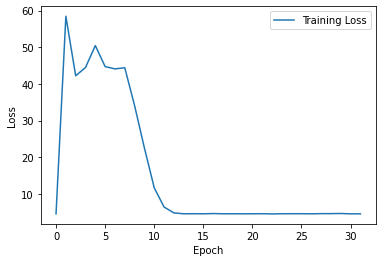

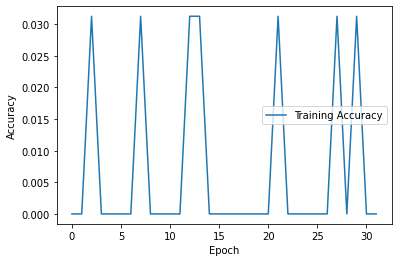

In [10]:
plt.plot(history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
tf.keras.backend.clear_session()
test_loss = 0
test_accuracy = 0
test_batches = 0

for batch in testing_batches:
  print(f"Batch: {test_batches}/{len(testing_batches)}",end='\r')
  images, labels = batch
  loss, accuracy = model.evaluate(images, labels,verbose=False)
  test_loss += loss
  test_accuracy += accuracy
  test_batches += 1
print(f"Average Loss: {test_loss/test_batches}   Average Accuracy: {test_accuracy/test_batches}")

Average Loss: 4.618381638601036   Average Accuracy: 0.008095854922279792
